# Zomie Outbreak in a City

동작환경:
* Julia v1.8.3
* Agents v5.6.2
* InteractiveDynamics v0.21.11
* CairoMakie v0.8.13
* GLMakie v0.6.13

In [1]:
import Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

In [2]:
using Agents
using Random
using PrettyPrint:pprintln

In [3]:
using Graphs
using HTTP
using JSON
using LightOSM
using LightXML
using SparseArrays
using Random

using OSMMakie

In [4]:
@agent Zombie OSMAgent begin
    infected::Bool
    speed::Float64
end

In [5]:
collect(zip(fieldnames(Zombie),fieldtypes(Zombie)))

4-element Vector{Tuple{Symbol, DataType}}:
 (:id, Int64)
 (:pos, Tuple{Int64, Int64, Float64})
 (:infected, Bool)
 (:speed, Float64)

In [6]:
@show Zombie

Zombie = Zombie


Zombie

모델은 하나의 지도가 있고 지도에 100명의 agent들이 주변에 무작위로 흩어져 있다.
좀비들은 자신의 일정이 있고 새로운 어떤 목적지로 여행할 필요가 있다.
불행하게도 그들중 하나는 좀비로 바뀌었고 가까이 다가 오는 사람은 감염되기 시작 할 것이다

### 서울 시청 주변 OSM 다운로드
URL : https://www.openstreetmap.org/export#map=15/37.5659/126.9798&layers=TN
* minlat =37.5544    (bottom)
* minlon = 126.9597  (left)
* maxlat = 37.5774   (top)
* maxlon = 126.9999  (right)

In [7]:
function wait_for_overpass()
    count = 0
    is_available = true
    while !LightOSM.is_overpass_server_availabile()
        if count == 7 is_available = false end
        count == 7 && break
        count += 1
        @info "Waiting for overpass server..."
        sleep(5*count)        
    end
    return is_available
end

wait_for_overpass (generic function with 1 method)

In [8]:
area = (
    minlat = 37.5544,  # bottom
    minlon = 126.9597, # left
    maxlat = 37.5774,  # top
    maxlon = 126.9999, # right
)

(minlat = 37.5544, minlon = 126.9597, maxlat = 37.5774, maxlon = 126.9999)

In [9]:
filenames = ["map.osm","map.json"]
formats = [:osm, :json]
for (filename, format) in zip(filenames, formats)
    try
        wait_for_overpass()
        data = download_osm_network(:bbox; # rectangular area
            area...,
            network_type = :drive,
            metadata = false,
            download_format=format,
            save_to_file_location=filename
            )
    catch err
        # Sometimes gets HTTP.ExceptionRequest.StatusError in tests
        # due to connection to overpass
        !isa(err, HTTP.ExceptionRequest.StatusError) && rethrow()
    end
end

### Load Map & Display

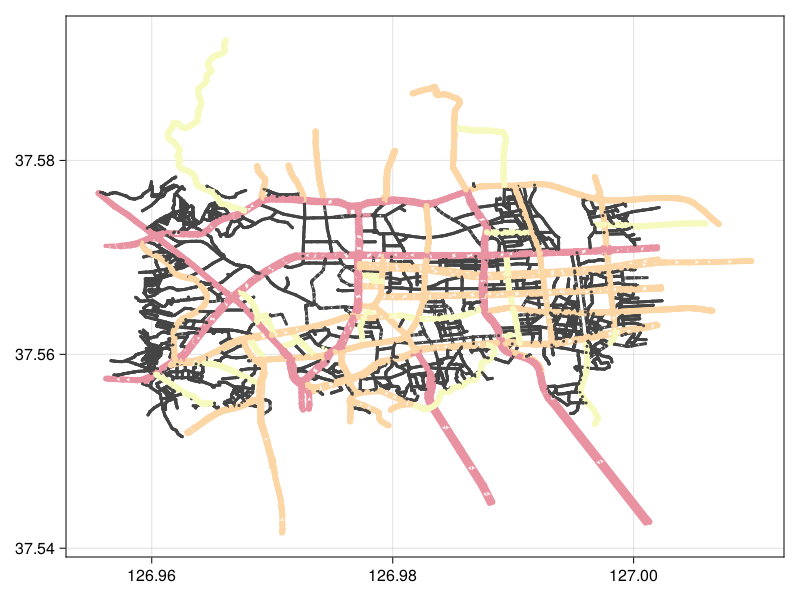

In [25]:
let
    osm = graph_from_file(filenames[1];
        graph_type = :light, # SimpleDiGraph
        weight_type = :distance )

    fig, ax, plot = osmplot(osm)
end

### Initialize function

In [19]:
function initialize(;seed = 1234,map_path="map.osm")
#     map_path = OSM.test_map()
#     map_path = "map.osm"
    properties = Dict(:dt => 1/60)
    model = ABM(
        Zombie,
        OpenStreetMapSpace(map_path);
        properties = properties,
        rng = Random.MersenneTwister(seed)
    )
    
    for id in 1:100
        start = random_position(model)
        speed = rand(model.rng)*5.0 + 2.0 # Random speed from 2-7kmph
        human = Zombie(id,start,false,speed)
        add_agent_pos!(human,model)
        # 랜덤 루트를 찾기 위해 최대 50번 시도
        OSM.plan_random_route!(human, model; limit = 50)
    end
    
    # 환자 zero르 특정 (경도, 위도)에 추가 한다.
    start = OSM.nearest_road((37.5597025,126.9856998), model)
    finish = OSM.nearest_node((37.5587025, 126.9846998), model)
    
    speed = rand(model.rng)*5.0 + 2.0
    zombie = add_agent!(start, model, true, speed)
    plan_route!(zombie,finish, model)
    
    return model
    
end

initialize (generic function with 1 method)

### Step function

In [20]:
function agent_step!(agent::Zombie, model::ABM)
    # 각 agent는 그들의 경로를 따라 진행한다.
    distance_left = move_along_route!(agent, model, agent.speed * model.dt)
    
    if is_stationary(agent, model) && rand(model.rng) < 0.1
        # 정지해 있을 때 다른 어떤 곳으로 갈 10% 기회를 준다.
        OSM.plan_random_route!(agent, model; limit = 50)
        
        # 새로운 경로에서 출발하고 남은 거리를 이동한다.
        move_along_route!(agent, model, distance_left)
    end
    
    if agent.infected
        # 이 agent가 좀비인 경우 근처에 있는 agent중 아주 가까이(10m 이내) 있는 경우 감염될 것이다.
        map(i->model[i].infected = true, nearby_ids(agent, model, 0.01))
    end
    return
end

agent_step! (generic function with 1 method)

### Visualising the fall of humanity

In [21]:
using InteractiveDynamics

In [22]:
ac(agent) = agent.infected ? :red :  :green
as(agent) = agent.infected ? 10 : 8
plotkwargs = (;
    ac = ac,
    as = as,
    title = "Zombie outbreak",
)

(ac = ac, as = as, title = "Zombie outbreak")

In [23]:
let
#     display = run(`bash -c "echo & echo \$DISPLAY"`)
    ENV["DISPLAY"]="localhost:13.0"
    using GLMakie
    GLMakie.activate!()
    
    model = initialize()
    fig, ax, abmobs = abmplot(model;
        agent_step!,        
        plotkwargs...)
   
    display(fig)      
end

GLMakie.Screen(...)

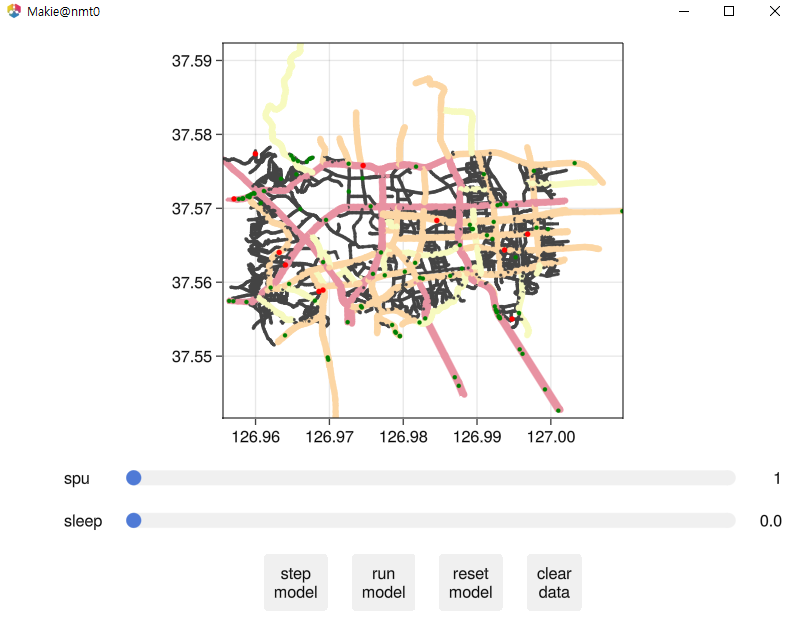

### Video

In [24]:
let
    using CairoMakie
    CairoMakie.activate!()
    
    model = initialize()
    abmvideo("outbreak.mp4",model,agent_step!;
        plotkwargs...)
end

<!-- <video width="auto" controls autoplay loop source src="outbreak.mp4" type="video/mp4"/> -->
<video width="auto" controls autoplay loop source src="https://julialang.kr/wp-content/uploads/2022/12/outbreak.mp4" type="video/mp4"/>